# 📘 STORE PRODUCTIVITY & PERFORMANCE TRACKING
### Understanding Revenue Quality Across Stores

**Role context:** Senior Data Analyst  
**Tools:** DuckDB (SQL), Python  
**Dataset:** Sample Superstore (public dataset)


## A. Executive Summary
This analysis evaluates store productivity using Region as a proxy for store-level operations.

Results show that productivity varies significantly across regions, not only in GMV scale but also in margin efficiency.
Some regions generate high revenue but underperform on profitability, indicating operational or pricing inefficiencies.

The findings highlight the importance of managing store productivity beyond topline growth.
tion.



## B. Business Context & Question
In the absence of explicit store identifiers, this analysis uses Region as a proxy
to evaluate productivity differences across operational units.

Business Question:
Which regions deliver the highest productivity in terms of GMV and margin efficiency?



## ⏭️ 0. Data Preparation (SQL via DuckDB)

In [4]:
import pandas as pd
import os

path_folder = r"C:\Users\yohan\workstation\fore\Promo Effectiveness Analysis"
files = os.listdir(path_folder)
file_target = next((f for f in files if f.endswith('.csv')), None)

if file_target:
    full_path = os.path.join(path_folder, file_target)
    
    try:
        # Percobaan 1: utf-8 (default)
        df = pd.read_csv(full_path)
    except UnicodeDecodeError:
        try:
            # Percobaan 2: latin1 (umum untuk file Windows/Excel)
            print("UTF-8 gagal, mencoba encoding latin1...")
            df = pd.read_csv(full_path, encoding='latin1')
        except UnicodeDecodeError:
            # Percobaan 3: ISO-8859-1
            print("latin1 gagal, mencoba encoding ISO-8859-1...")
            df = pd.read_csv(full_path, encoding='ISO-8859-1')

    print(f"\nDataFrame '{file_target}' berhasil dimuat!")
    print(df.head())
    
    # Simpan dataframe ke variabel global untuk analisis selanjutnya
    # %store df # Jika di Jupyter, ini berguna
else:
    print("\nTidak ada file CSV yang ditemukan.")

UTF-8 gagal, mencoba encoding latin1...

DataFrame 'Sample - Superstore.csv' berhasil dimuat!
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

In [8]:
data_prep = df

## ⏭️ 1. BASELINE STORE PERFORMANCE (GMV & MARGIN)

In [15]:
query = """
SELECT
    Region AS STORE,
    ROUND(SUM(SALES), 2) AS GMV,
    ROUND(SUM(PROFIT), 2) AS PROFIT,
    ROUND(SUM(PROFIT) / SUM(SALES) * 100, 2) AS MARGIN_PCT,
    COUNT(DISTINCT "Customer ID") AS CUSTOMERS
FROM data_prep
GROUP BY Region
ORDER BY GMV DESC
"""

store_baseline = duckdb.query(query).to_df()
store_baseline


,STORE,GMV,PROFIT,MARGIN_PCT,CUSTOMERS
0,West,725457.82,108418.45,14.94,686
1,East,678781.24,91522.78,13.48,674
2,Central,501239.89,39706.36,7.92,629
3,South,391721.91,46749.43,11.93,512


### Insight

The West region is the strongest overall performer, generating the highest GMV while maintaining the best margin among all stores. This indicates a healthy balance between scale and profitability and positions West as a benchmark for store performance.

The East region delivers comparable GMV but with slightly lower margin, suggesting solid demand but potential room for improvement in pricing or promotional efficiency.

Central shows a clear performance gap. Despite relatively high GMV, it delivers the lowest margin, indicating that sales are being driven by low-quality revenue, potentially due to aggressive discounting, unfavorable product mix, or operational inefficiencies.

South is the smallest store by GMV but maintains a relatively healthy margin, suggesting efficient operations at a smaller scale.

Overall, GMV alone does not fully reflect store performance. Margin quality and customer contribution must be considered to accurately assess store productivity and identify improvement opportunities.



## ⏭️ 2. PRODUCTIVITY NORMALIZATION

In [17]:
query = """
SELECT
    Region AS STORE,
    ROUND(SUM(SALES) / COUNT(DISTINCT "Customer ID"), 2) AS GMV_PER_CUSTOMER,
    ROUND(SUM(PROFIT) / COUNT(DISTINCT "Customer ID"), 2) AS PROFIT_PER_CUSTOMER,
    ROUND(SUM(PROFIT) / SUM(SALES) * 100, 2) AS MARGIN_PCT
FROM data_prep
GROUP BY Region
ORDER BY GMV_PER_CUSTOMER DESC
"""

store_productivity = duckdb.query(query).to_df()
store_productivity


,STORE,GMV_PER_CUSTOMER,PROFIT_PER_CUSTOMER,MARGIN_PCT
0,West,1057.52,158.04,14.94
1,East,1007.09,135.79,13.48
2,Central,796.88,63.13,7.92
3,South,765.08,91.31,11.93


### Insight

West remains the most productive store, generating the highest GMV per customer and the strongest profit per customer. This confirms that West’s performance is not driven by volume alone, but also by high customer value.

East follows closely behind West, showing solid customer productivity and healthy margin levels. This indicates a scalable store with relatively balanced economics.

Central shows a significant productivity issue. Both GMV per customer and profit per customer are materially lower than other stores, while margin is the weakest overall. This suggests that Central’s performance problem is structural rather than volume-related.

South generates lower GMV per customer, but delivers higher profit per customer than Central. Despite its smaller scale, South operates more efficiently and converts revenue into profit more effectively.

Overall, customer-level productivity reveals that Central is the weakest performer, while West sets the benchmark for both scale and efficiency.


## ⏭️ 3. STORE MIX & DISCOUNT DEPENDENCY

In [20]:
query = """
SELECT
    Region AS STORE,
    CASE
        WHEN Discount = 0 THEN 'No Discount'
        WHEN Discount <= 0.10 THEN 'Low (0–10%)'
        WHEN Discount <= 0.20 THEN 'Medium (10–20%)'
        ELSE 'High (>20%)'
    END AS DISCOUNT_BUCKET,
    ROUND(SUM(SALES), 2) AS GMV,
    ROUND(
        SUM(SALES) / SUM(SUM(SALES)) OVER (PARTITION BY Region) * 100,
        2
    ) AS GMV_SHARE_PCT,
    ROUND(SUM(PROFIT) / SUM(SALES) * 100, 2) AS MARGIN_PCT
FROM data_prep
GROUP BY
    Region,
    CASE
        WHEN Discount = 0 THEN 'No Discount'
        WHEN Discount <= 0.10 THEN 'Low (0–10%)'
        WHEN Discount <= 0.20 THEN 'Medium (10–20%)'
        ELSE 'High (>20%)'
    END
ORDER BY STORE, GMV_SHARE_PCT DESC
"""

store_discount_mix = duckdb.query(query).to_df()
store_discount_mix


,STORE,DISCOUNT_BUCKET,GMV,GMV_SHARE_PCT,MARGIN_PCT
0,Central,No Discount,243150.64,48.51,31.31
1,Central,High (>20%),129134.10,25.76,-40.57
2,Central,Medium (10–20%),121220.05,24.18,11.59
3,Central,Low (0–10%),7735.10,1.54,24.80
4,East,No Discount,341742.54,50.35,30.84
5,East,High (>20%),145870.40,21.49,-28.85
6,East,Medium (10–20%),144534.06,21.29,14.61
7,East,Low (0–10%),46634.25,6.87,15.25
8,South,No Discount,215983.16,55.14,29.16
9,South,Medium (10–20%),105021.75,26.81,8.24


### Insight

Across all stores, non-discounted transactions consistently contribute the largest share of GMV while delivering the highest margins. This confirms that baseline demand is strong and not primarily driven by promotions.

Central stands out as the most discount-dependent store. Over 25% of its GMV comes from high-discount transactions, which generate deeply negative margins. This heavy reliance on aggressive promotions explains Central’s weak overall profitability despite reasonable GMV.

East and South show a more balanced discount mix, but still suffer margin erosion from high-discount campaigns. Medium discounts contribute meaningful GMV but deliver significantly lower margins compared to non-discounted sales.

West exhibits the healthiest discount structure. The majority of GMV comes from medium and non-discounted transactions, while exposure to high discounts is minimal. This explains West’s superior performance in both GMV and margin.

Overall, excessive reliance on high discounts is a clear driver of poor store-level profitability, particularly in Central.


## ⏭️ 4. GMV Share by Discount Bucket per Store

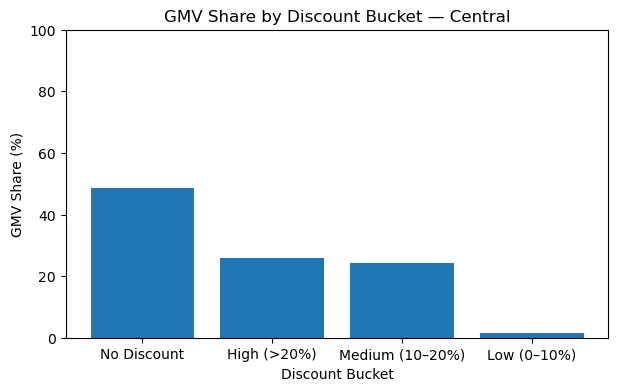

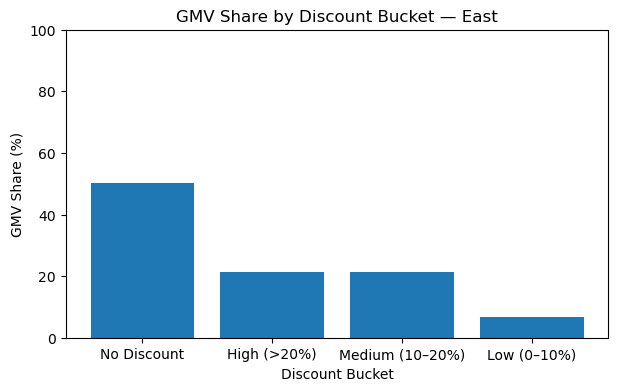

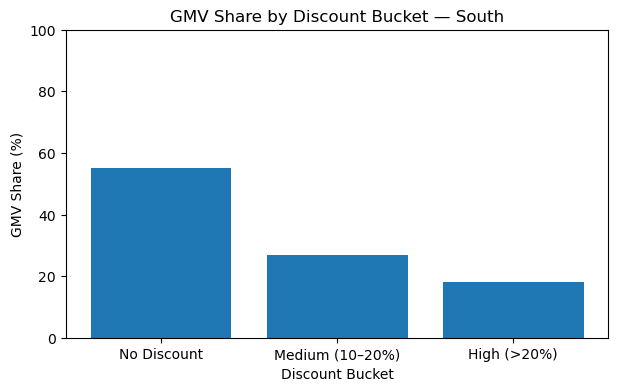

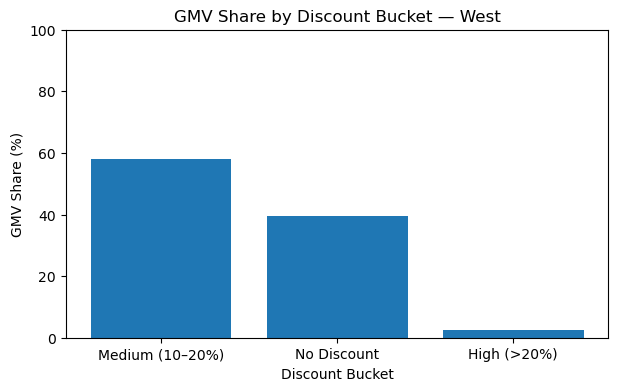

In [24]:
import matplotlib.pyplot as plt

for store in store_discount_mix['STORE'].unique():
    subset = store_discount_mix[store_discount_mix['STORE'] == store]
    
    plt.figure(figsize=(7,4))
    plt.bar(subset['DISCOUNT_BUCKET'], subset['GMV_SHARE_PCT'])
    plt.title(f'GMV Share by Discount Bucket — {store}')
    plt.ylabel('GMV Share (%)')
    plt.xlabel('Discount Bucket')
    plt.ylim(0, 100)
    plt.show()


### Insight

The charts clearly show structural differences in how stores rely on discounts to generate GMV.

Central is the most discount-dependent store. A significant portion of its GMV comes from high-discount transactions, despite these discounts delivering deeply negative margins. This indicates that Central relies on price cuts to sustain volume, leading to structurally weak profitability.

East demonstrates a more balanced discount structure, with the majority of GMV coming from non-discounted and medium-discount transactions. However, exposure to high discounts remains meaningful and continues to pressure margins.

South generates most of its GMV without discounts, supplemented by medium discounts. While its scale is smaller, the discount structure is healthier than Central and supports better margin conversion.

West shows the most disciplined discount strategy. GMV is primarily driven by non-discounted and medium-discount sales, with minimal reliance on high discounts. This disciplined approach explains West’s strong margin and productivity performance.

Overall, stores with lower dependency on high discounts consistently achieve better profitability and customer productivity.


## ⏭️ 5. FINAL DIAGNOSTIC

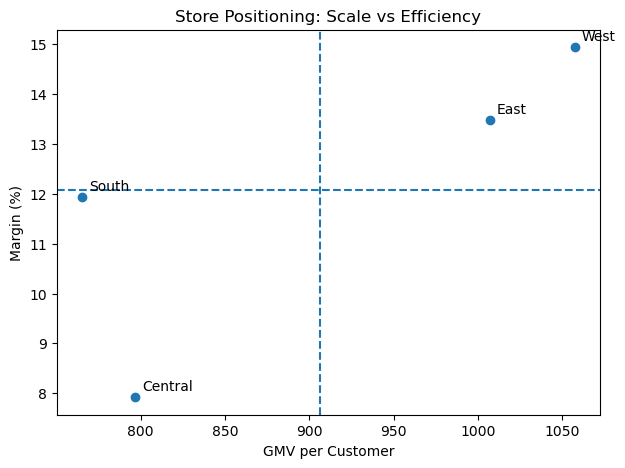

In [26]:
plt.figure(figsize=(7,5))

plt.scatter(
    store_productivity['GMV_PER_CUSTOMER'],
    store_productivity['MARGIN_PCT']
)

for i, store in enumerate(store_productivity['STORE']):
    plt.annotate(
        store,
        (store_productivity['GMV_PER_CUSTOMER'][i],
         store_productivity['MARGIN_PCT'][i]),
        textcoords="offset points",
        xytext=(5,5)
    )

plt.axhline(store_productivity['MARGIN_PCT'].mean(), linestyle='--')
plt.axvline(store_productivity['GMV_PER_CUSTOMER'].mean(), linestyle='--')

plt.xlabel('GMV per Customer')
plt.ylabel('Margin (%)')
plt.title('Store Positioning: Scale vs Efficiency')
plt.show()


### Insight

The scale-versus-efficiency matrix clearly separates stores into distinct strategic groups.

West is positioned in the high-scale, high-efficiency quadrant. It generates the highest GMV per customer while maintaining the strongest margin, making it the benchmark store for best practices.

East also operates at high scale with solid efficiency, though slightly below West in margin. This suggests East is a strong growth candidate with targeted optimization opportunities.

South sits in the low-scale but high-efficiency quadrant. While its GMV per customer is below average, it converts revenue into profit effectively, indicating operational discipline that could support controlled scaling.

Central is located in the low-scale, low-efficiency quadrant. It generates below-average GMV per customer and the weakest margin, confirming that its performance issues are structural rather than demand-driven.

This positioning highlights that not all stores should be treated equally. Different store archetypes require different strategic interventions.


## ⏭️ EXECUTIVE RECOMMENDATIONS

1. **Scale Best-in-Class Stores (West, East)**
   - Use West as the operational and commercial benchmark.
   - Selectively scale East by applying West’s discount discipline and product mix strategies.
2. **Fix Before Scaling (Central)**
   - Reduce dependency on high-discount campaigns.
   - Review pricing, promotion mix, and product assortment.
   - Focus on improving margin quality before pursuing GMV growth.
3. **Selective Expansion (South)**
   - Gradually increase traffic and exposure while maintaining pricing discipline.
   - Test medium-discount campaigns with strict margin guardrails.
4. **Store-Specific Strategy Over One-Size-Fits-All**
   - Apply differentiated discount and pricing strategies by store archetype.
   - Track GMV per customer and margin as core store productivity KPIs.

Overall, sustainable growth should prioritize revenue quality over volume. Store-level decisions must balance scale and efficiency rather than maximize GMV alone.
